# Germanium telluride ferroelectric switching contrast

This is an example script to show how to use pyasf to calculate the switching contrast of several Bragg reflections as a function of energy, e.g., near an absorption edge.

In [1]:
%matplotlib notebook

In [2]:
import pylab as pl
import pyasf
import sympy as sp # symbolic computing
from IPython.display import display, Math
print_latex = lambda x: display(Math(sp.latex(x)))
# sp.init_printing()

In [3]:
ls

'GeTe switching.ipynb'   ICSD_188458.cif   switch_contrast.txt


In [4]:
GeTe = pyasf.unit_cell("ICSD_188458.cif") # initialize crystal structure object

Multiple settings found in space group 160
  Identified symbol `R3m:h' from .cif entry `r3m:h'
Trigonal (hexagonal setting)


Let's look at the positions in the asymmetric unit cell...

In [5]:
print_latex(GeTe.AU_positions)

<IPython.core.display.Math object>

Comparing with the high-temperature cubic unit cell one can see that the atoms are displaced away from the high symmetry positions (1/4 and 3/4) by the same amount ($\delta = 0.0097$ in *z* direction).
In Practice, this displacement may change significantly (piezo- or pyroelectricity?) or inverted (ferroelectric switching).


Therefore, it is useful to define a variable which describes this displacement:

In [6]:
delta = sp.Symbol("delta") # Just a symbol
delta_val = 0.0097 # The initial value of the symbol

GeTe.subs[delta] = delta_val # needed later

GeTe.AU_positions["Ge1"][2] = sp.S("1/4") - delta # redefine the positions
GeTe.AU_positions["Te1"][2] = sp.S("3/4") + delta # redefine the positions

Yes, 1/4 is more precise than 0.25. There is a numerical limit to the precision so 0.2499999999999 = 0.25.
Using sympy Symbols is more precise and in crystallography it is important especially when describing special (high symmetry) Wyckoff positions.

The **`subs`** dictionary contains the numerical values used as substitute for final evaluation.


Let's calculate the site symmetry and build the unit cell:

In [7]:
GeTe.get_tensor_symmetry()
GeTe.build_unit_cell()

Now we have a **`positions`** dictionary containing the whole unit cell and some other stuff:

In [8]:
print_latex(GeTe.positions)

<IPython.core.display.Math object>

In [9]:
GeTe.multiplicity

defaultdict(int, {u'Ge1': 3, u'Te1': 3})

### Now we define an energy range in eV an play around a bit...

In [10]:
E = pl.linspace(7000, 30000, 1001)

<IPython.core.display.Javascript object>


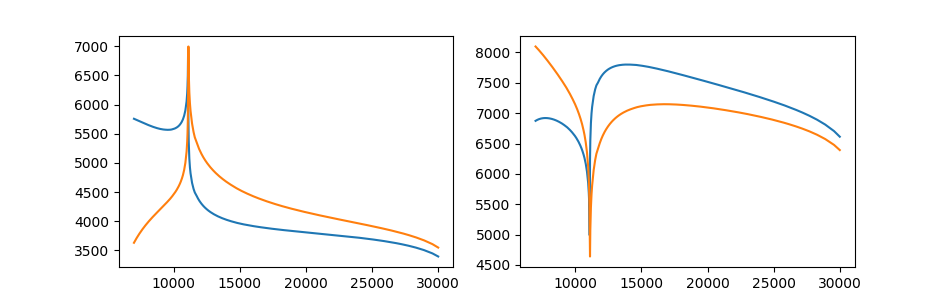

In [11]:
fig, ax = pl.subplots(1,2, figsize=(9.5,3))

GeTe.subs[delta] = delta_val 
F = GeTe.DAFS(E, (0,0,3), Uaniso=False) # because no anisotropic Uij is defined...
ax[0].plot(E, abs(F)**2)

GeTe.subs[delta] = -delta_val 
F = GeTe.DAFS(E, (0,0,3), Uaniso=False)
ax[0].plot(E, abs(F)**2)

GeTe.subs[delta] = delta_val 
F = GeTe.DAFS(E, (3,3,6), Uaniso=False)
ax[1].plot(E, abs(F)**2)

GeTe.subs[delta] = -delta_val 
F = GeTe.DAFS(E, (3,3,6), Uaniso=False)
ax[1].plot(E, abs(F)**2)


In [16]:
print_latex(GeTe.F_0)

<IPython.core.display.Math object>

So we see already there is a significant contrast when switching the ferroelectric domains (inverting the displaecment). In practice, a strong relative change in intensity is easier to measure which is why weak reflections are often better...

Let's now do a proper calculation of switching contrast for all reflections in a certain range of **Q** (momentum transfter). To increase speed, we don't recalculate the structure factor each time (is done in `.DAFS`). The crystal is not modified except for the numerical value of $\delta$, so no refreshing is needed... 

In [12]:
results = [] # some container to store results

GeTe.calc_structure_factor(Temp = False, DD=False, DQ=False) # calculate (`cache`) all structure factors

qmax = 1.5 # q=2*sin(theta)/lambda 

for R in GeTe.iter_rec_space(qmax): # iterate over all reflections in Ewald sphere
    #print R,
    GeTe.subs[delta] = delta_val
    F1 = GeTe.DAFS(E, R,  force_refresh=False, fwhm_ev=1)

    GeTe.subs[delta] = -delta_val
    F2 = GeTe.DAFS(E, R,  force_refresh=False, fwhm_ev=1)

    # minimum energy necessary to reach reflection:
    ## .theta is a symbolic expression
    ## .energy is just a symbol as well
    Emin = float(sp.sin(GeTe.theta.subs(GeTe.subs)) * GeTe.energy)
    
    if Emin>20000.:
        continue # skip if energy too high

    ind = E>Emin

    I1 = abs(F1)**2 # calculate intensity
    I2 = abs(F2)**2

    I1 = I1[ind]
    I2 = I2[ind]
    
    if I1.max()<1e-2 and I2.max()<1e-2: # Intensity too small?
        continue
    
    c = abs(pl.log10(I1/I2)) # relative contrast
    idx_max = c.argmax()
    
    cmax = 10**c[idx_max] # get the maximum contrast
    Imax = 0.5 * (I1+I2)[idx_max] # ... and its intensity
    Emax = E[ind][idx_max] # ... and its energy
    theta_max = GeTe.theta_degrees(Emax) # ... as well as the theta value

    h,k,l = R
    
    results.append([h, k, l, cmax, Imax, Emax, theta_max])
    print(results[-1])
    
    


[6, -2, 2, 1.0907102624018978, 6375.0370166503708, 11117.0, 55.7378867663657]
[6, -2, -1, 1.1538532315328376, 1234.2554466260312, 11922.0, 49.9980983600527]
[6, -3, 3, 1.4486321569952509, 1707.9521206159402, 11370.0, 53.3164324815257]
[6, -3, 0, 1.0, 9133.8519596661808, 8955.0, 88.0424263985262]
[6, -3, -3, 1.4486321569952496, 1707.9521206159397, 11370.0, 53.3164324815257]
[6, -4, 1, 1.1538532315328371, 1234.2554466260308, 11922.0, 49.9980983600527]
[6, -4, -2, 1.0907102624018969, 6375.0370166503726, 11117.0, 55.7378867663657]
[5, 0, 5, 1.6491564144545576, 2333.1613414644453, 11186.0, 54.3467484899012]
[5, 0, 2, 1.082103056108616, 7087.0704557258832, 11117.0, 51.4157117265055]
[5, 0, -1, 1.1518313315398283, 1266.8492807736816, 11922.0, 46.3857049171429]
[5, 0, -4, 1.1795616091993926, 6551.1892248408385, 11117.0, 53.3607661108287]
[5, -1, 6, 1.2642628849408093, 6634.5127096116084, 11117.0, 50.9171812830929]
[5, -1, 3, 1.5010410906095848, 1697.6985233323244, 8104.0, 85.9103003907585]
[5,

[2, 0, 14, 1.7119455434815556, 4355.5365867671298, 11117.0, 52.6569368625550]
[2, 0, 11, 1.5501242533892001, 5446.4511459608784, 11117.0, 40.7987623268711]
[2, 0, 8, 1.2206120340927291, 14754.292308682143, 7000.0, 55.7739030860005]
[2, 0, 5, 1.8700887262823629, 3999.3445399799016, 7000.0, 40.0839977913605]
[2, 0, 2, 1.03898391623091, 29898.251885088619, 7000.0, 31.2912055800720]
[2, 0, -1, 1.2801199455268601, 2384.849079204781, 7000.0, 29.9384402869657]
[2, 0, -4, 1.0851015163903721, 25459.66569990541, 7000.0, 36.4235590198972]
[2, 0, -7, 1.80742748622968, 4952.3555020320036, 7000.0, 49.6133153657659]
[2, 0, -10, 1.3203145196670674, 10431.83485872137, 7000.0, 74.8802180585622]
[2, 0, -13, 1.5855298182441335, 5158.9742241351541, 11117.0, 48.3428526864470]
[2, -1, 15, 1.5848821422122594, 4894.4285367549674, 11117.0, 56.0035540482982]
[2, -1, 12, 1.4688162919399066, 6246.478536977359, 11117.0, 43.0409820805902]
[2, -1, 9, 1.692549745943754, 5919.5076487407805, 7000.0, 59.3662318606846]
[2

In [13]:
results = pl.array(results)

In [14]:
isort = results[:,3].argsort() 
results = results[isort[::-1]] # sort after contrast

In [22]:
columns=("h", "k", "l", "contrast", "intensity", "energy", "theta")
pl.savetxt("switch_contrast.txt", results,
           fmt="  %5i %5i %5i %10.3f %10.1f %10.1f %10.2f",
           header = "%5s %5s %5s %10s %10s %10s %10s"%columns)

In [23]:
results

array([[4, -3, -5, ..., 2653.6470924510954, 7000.0, 78.3912479501322],
       [4, -1, 5, ..., 2653.6470924510886, 7000.0, 78.3912479501322],
       [3, -1, -5, ..., 3383.9313619921895, 7000.0, 50.5493113882888],
       ..., 
       [6, -3, 0, ..., 9133.8519596661808, 8955.0, 88.0424263985262],
       [3, 0, 0, ..., 21296.888983850087, 7000.0, 47.5753272455092],
       [5, -1, 0, ..., 11519.783701922113, 7897.0, 88.1668811047421]], dtype=object)